<h1>4. Model Selection </h1>

<h2>Contents</h2>

4.1 Introduction

4.2 Import, Load, Explore

    4.2.1 Loading Dataset
    
4.3. Initial Exploration

4.4. Model Selection

    4.4.1. Arima model
    
    4.4.2. Prophet
    
    4.4.3. LSTM

4.5. Summary

<h2>4.1 Introduction</h2>

In this phase, I'll explore 3 different models to forecast, after evaluating each model, the final model will be selected.

<h2>4.2 Installing Packeges</h2>

In [2]:
%%capture

!pip install pmdarima
!pip install Cython
!pip install pystan==2.19.1.1
!pip install prophet
!pip install tensorflow

In [3]:
#Importing relevant libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint 

from tensorflow.keras.losses import MeanSquaredError 
from tensorflow.keras.metrics import RootMeanSquaredError 

**4.2.1 Loading Datasets**

In [4]:
train_data = pd.read_csv('C:/Users/umitk/OneDrive/Documents/myspringboard/Capstone_3_Demand_Forecast/Data/train_forecast.csv')
train_data

,WeekStartDate,Category,CustomerPerCategory,Quantity
0,2011-01-10,-1,6.944016e+08,16931
1,2011-01-10,0,1.048645e+09,38008
2,2011-01-10,1,1.209392e+08,8062
3,2011-01-10,2,6.718824e+06,96
4,2011-01-10,3,4.923072e+07,2473
...,...,...,...,...
559,2011-09-26,3,4.923072e+07,4639
560,2011-09-26,4,9.780713e+07,3879
561,2011-09-26,5,3.590108e+07,1200
562,2011-09-26,6,5.172819e+07,2429


In [5]:
train_data.shape

(564, 4)

In [6]:
train_data['WeekStartDate'] = pd.to_datetime(train_data['WeekStartDate'])

In [8]:
#Loading testing data
test_data = pd.read_csv('C:/Users/umitk/OneDrive/Documents/myspringboard/Capstone_3_Demand_Forecast/Data/test_forecast.csv', parse_dates=['WeekStartDate'])
print(test_data.shape)
#Spliting into testing and validation data
val_data = test_data.iloc[:-70]
test_data = test_data.iloc[-70:]
val_data.shape, test_data.shape

(141, 4)


((71, 4), (70, 4))

In [9]:
train_data = train_data.set_index('WeekStartDate')
test_data = test_data.set_index('WeekStartDate')
val_data = val_data.set_index('WeekStartDate')

In [10]:
# subseting records of Category 0 validation data and test data.
Category_0_train = train_data[train_data['Category'] == 0]
Category_0_val = val_data[val_data['Category'] == 0]
Category_0_test = test_data[test_data['Category'] == 0]

<h2>4.3 Initial Exploration</h2>

<Figure size 1200x600 with 0 Axes>

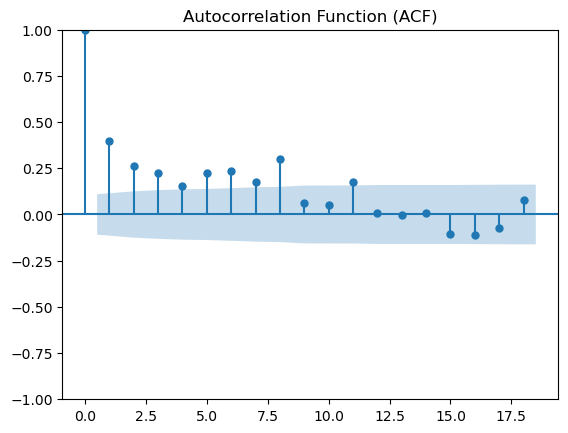

<Figure size 1200x600 with 0 Axes>

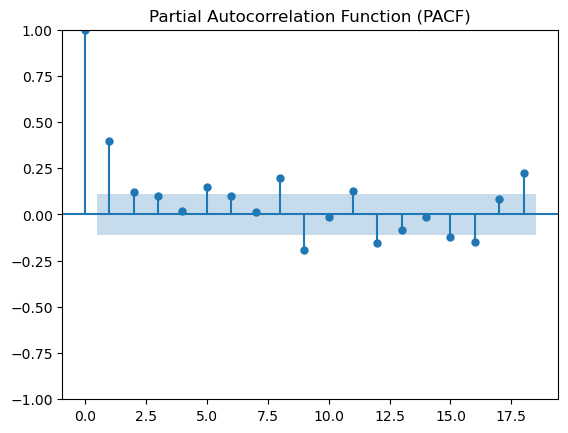

In [11]:
plt.figure(figsize=(12, 6))
plot_acf(Category_0_train['Quantity'], lags=18, alpha = 0.5)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(Category_0_train['Quantity'], lags=18, alpha = 0.5)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [12]:
#checking for stationarity

def ad_test(data):
    result = adfuller(data, autolag = 'AIC')
    print('ADF: ', result[0])
    print('p-value: ', result[1])
    print('Num of lags: ', result[2])
    print('Num of observations used:', result[3])
    print('Critical values: ')
    for key, val in result[4].items():
        print(key, ":", val)

In [13]:
ad_test(Category_0_train['Quantity'])

ADF:  0.6048411522578381
p-value:  0.9877343493774601
Num of lags:  10
Num of observations used: 27
Critical values: 
1% : -3.6996079738860943
5% : -2.9764303469999494
10% : -2.627601001371742


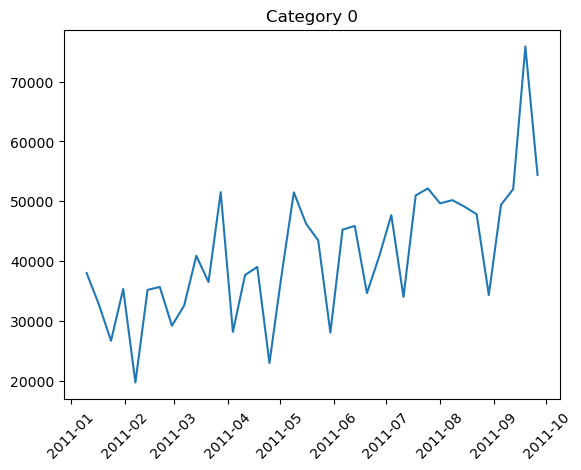

In [14]:
plt.plot(Category_0_train['Quantity'])
plt.title('Category 0')
plt.xticks(rotation = 45)
plt.show()

In [15]:
stepwise_fit = auto_arima(Category_0_train['Quantity'],
                         trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=801.663, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=794.361, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=799.730, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=791.456, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=792.876, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=790.057, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=783.444, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=798.205, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=788.693, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.487 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -387.722
Date:                Wed, 28 Aug 2024   AIC                            783.444
Time:                        13:54:03   BIC                            789.888
Sample:                    01-10-2011   HQIC                           785.716
                         - 09-26-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    754.8974    310.032      2.435      0.015     147.245    1362.549
ar.L1         -0.0046      0.354     -0.013      0.990      -0.698       0.689
ma.L1         -0.9753      0.235     -4.146      0.000      -1.436      -0.514
sigma2      8.917e+07      0.001   8.34e+10      0.000    8.92e+07    8.92e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.76   Prob(JB):                         0.73
Heteroskedasticity (H):               1.40   Skew:                             0.03
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.92e+26. Standard errors may be unstable.
"""

<h2>4.4 Model Selection</h2>

**4.4.1 Arima Model**

In [16]:
model_ARIMA = ARIMA(Category_0_train['Quantity'], order = (0,1,1))
results_ARIMA = model_ARIMA.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                   38
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -391.351
Date:                Wed, 28 Aug 2024   AIC                            786.703
Time:                        13:55:53   BIC                            789.925
Sample:                    01-10-2011   HQIC                           787.839
                         - 09-26-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7072      0.169     -4.174      0.000      -1.039      -0.375
sigma2      9.489e+07   2.52e-10   3.77e+17      0.000    9.49e+07    9.49e+07
Ljung-Box (L1) (Q):                   0.91   Jarque-

C:\Users\umitk\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\umitk\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\umitk\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [17]:
# Evaluating the ARIMA model

start_date = Category_0_val.index[0]
end_date = Category_0_val.index[-1] 

In [18]:
pred = results_ARIMA.predict(start = start_date, end = end_date)

<Axes: xlabel='WeekStartDate'>

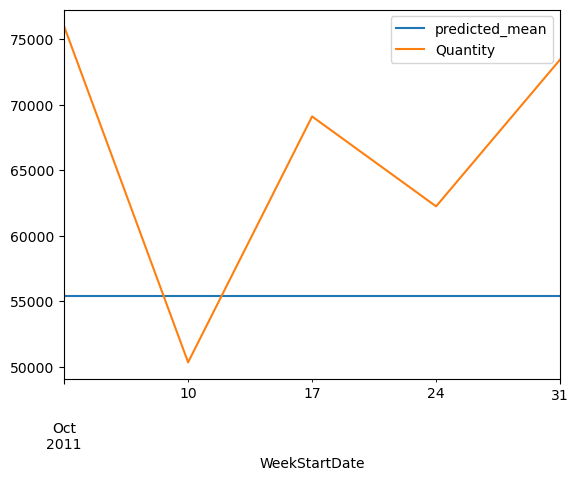

In [19]:
pred.plot(legend = True)
Category_0_val['Quantity'].plot(legend = True)

In [20]:
residuals = Category_0_val['Quantity'] - pred

In [21]:
#Evaluating the model

# MAE
mae = mean_absolute_error(Category_0_val['Quantity'], pred)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(Category_0_val['Quantity'], pred)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((Category_0_val['Quantity']- pred) / Category_0_val['Quantity'])) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 12859.89
MSE: 202323021.1
RMSE: 14224.03
MAPE: 18.52%


**4.4.2 Prophet Model**

In [22]:
train = pd.DataFrame({
    'ds': Category_0_train.index,
    'y': Category_0_train['Quantity']
})

In [23]:
m = Prophet(changepoint_prior_scale=0.5)
prophet_model = m.fit(train)

13:57:44 - cmdstanpy - INFO - Chain [1] start processing
13:57:44 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
#Prediction

future = m.make_future_dataframe(periods = 5 , freq = 'W')
forecast = m.predict(future)

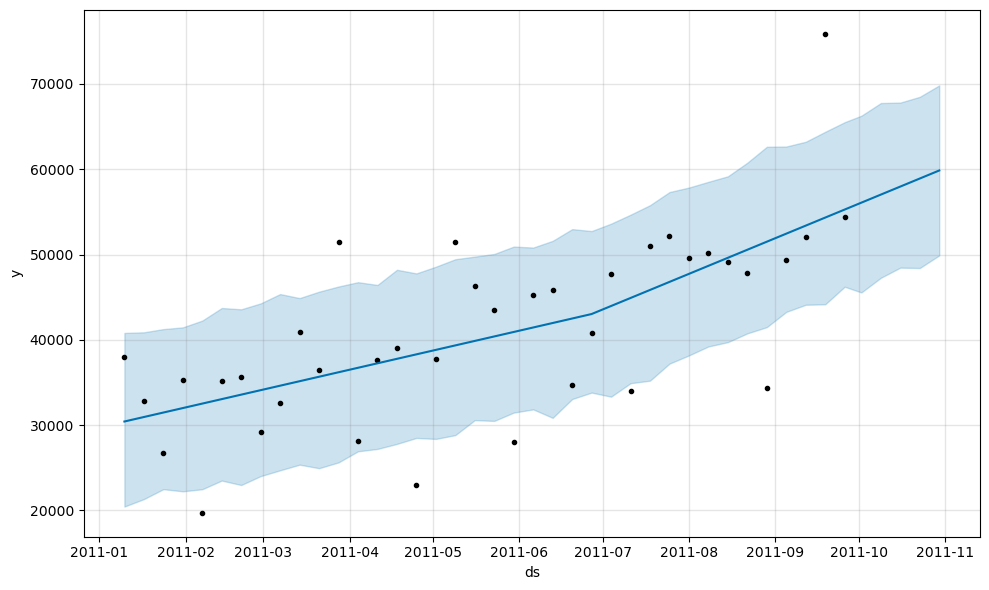

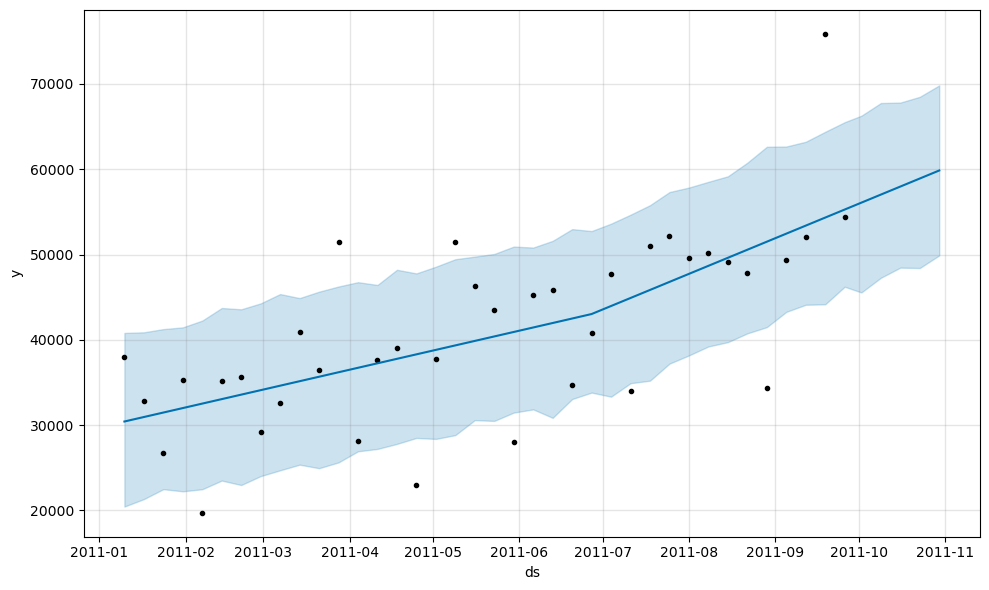

In [25]:
m.plot(forecast)

In [26]:
predicted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-5:]
predicted

,ds,yhat,yhat_lower,yhat_upper
38,2011-10-02,56086.020411,45556.055894,66278.210211
39,2011-10-09,57028.697687,47272.633507,67763.367489
40,2011-10-16,57971.374963,48464.166656,67819.145271
41,2011-10-23,58914.052239,48417.925482,68492.132691
42,2011-10-30,59856.729515,49900.149244,69833.456177


In [27]:
predicted_p = predicted[['ds', 'yhat']].set_index('ds')

<Axes: xlabel='WeekStartDate'>

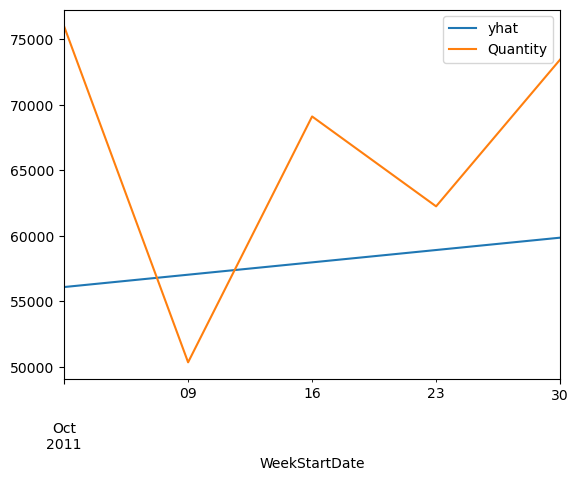

In [28]:
predicted_p['yhat'].plot(legend = True)
Category_0_val['Quantity'].plot(legend = True)

In [32]:
#Evaluating the model

# MAE
mae = mean_absolute_error(Category_0_val['Quantity'], predicted['yhat'].values)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(Category_0_val['Quantity'], predicted['yhat'].values)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((Category_0_val['Quantity']- predicted['yhat'].values) / Category_0_val['Quantity'])) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 10936.5
MSE: 152308055.44
RMSE: 12341.31
MAPE: 15.90%


**4.4.3 LSTM**

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(Category_0_train['Quantity'].values.reshape(-1, 1) )

val_scaled = scaler.fit_transform(Category_0_val['Quantity'].values.reshape(-1, 1) )

test_scaled = scaler.fit_transform(Category_0_test['Quantity'].values.reshape(-1, 1) )

In [34]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [37]:
X, y = create_sequences(train_scaled, 1)

X = X.reshape((X.shape[0], X.shape[1], 1))

In [38]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(64, input_shape=(X.shape[1], 1)))
model_LSTM.add(Dense(1, activation='relu'))
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(32, return_sequences = True, input_shape=(X.shape[1], 1)))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(12, return_sequences = True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(6, return_sequences = True))
model_LSTM.add(Dropout(0.2))


model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
model_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 12)               │           2,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 12)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1, 6)                │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 6)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1, 1)                │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,975 (27.25 KB)

 Trainable params: 6,975 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model_LSTM.fit(X, y, epochs = 50, batch_size = 10)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.1692
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1773
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1477 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1595 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1417
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1675
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1307 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1196  
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1353 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1022 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0978 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0996 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1017 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0781 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0700 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━

In [42]:
def create_sequences_val(data, seq_length):
    sequences, targets = [], []
    for i in range(abs(len(data) - seq_length + 1)):
        seq = data[i:i + seq_length]
        target = data[i + seq_length - 1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [43]:
X_val, y_val  = create_sequences(val_scaled, 1)

In [44]:
loss = model_LSTM.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1782
Validation Loss: 0.1781555414199829


In [45]:
predictions = model_LSTM.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [46]:
predictions_reshaped = predictions.reshape(-1, 1)

predictions_original_scale = scaler.inverse_transform(predictions_reshaped)

In [47]:
predictions_original_scale = scaler.inverse_transform(predictions_reshaped)


compare_df = pd.DataFrame({'Actual': scaler.inverse_transform(y_val.reshape(-1, 1)).flatten(),
                            'Predicted': predictions_original_scale.flatten()})
print(compare_df)

         Actual     Predicted
0  36576.000000  59594.449219
1  70090.102217  49986.617188
2  57837.116558  56837.453125
3  77843.484549  54181.460938


In [48]:
actual_LSTM = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
pred_LSTM = predictions_original_scale.flatten()

In [49]:
pred_LSTM = pd.Series(pred_LSTM) 
actual_LSTM = pd.Series(actual_LSTM) 

<Axes: >

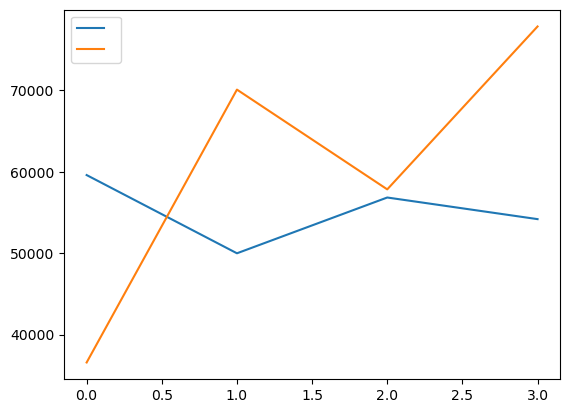

In [50]:
pred_LSTM.plot(legend = True)
actual_LSTM.plot(legend = True)

In [51]:
#Evaluating the model

# MAE
mae = mean_absolute_error(actual_LSTM, pred_LSTM.values)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(actual_LSTM, pred_LSTM.values)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((actual_LSTM- pred_LSTM.values) /actual_LSTM)) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 16945.91
MSE: 373722450.78
RMSE: 19331.9
MAPE: 30.94%


<h2>4.7 Summary</h2>

In this stage, I experimented with three different forecasting models for a specific category of product sales data. When analyzing the data trend, it was observed to be stationary, and no differencing was necessary before fitting the ARIMA model. The ARIMA model yielded a Mean Absolute Percentage Error (MAPE) of 17.62%, which, while acceptable, has room for improvement.

Among the three models tested, the Prophet model proved to be the most effective and adaptable to the dataset, achieving a MAPE of 14.41%. On the other hand, the LSTM model performed less satisfactorily, primarily due to the limited dataset of 48 weeks and the complexity of tuning numerous hyperparameters.

Taking all factors into account, the Prophet model was ultimately chosen for the modeling phase.